## ABOUBAKAR Ouattara

### TP3.3 Courbe de rendement gaussienne à deux facteurs

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Paramètres
T = 15  # Maturité
n = 1500  # Nombre de pas de temps
M = 10**4  # Nombre de trajectoires
h = T / n  # Taille d'un pas de temps

t = np.linspace(0, T, n+1)  # Points temporels

# Paramètres spécifiques aux processus
lambda_ = np.array([1.0, 0.1])  # lambda_1, lambda_2
theta = np.array([0.05, 0.05])  # theta_1, theta_2
sigma = np.array([0.05, 0.05])  # sigma_1, sigma_2
x0 = np.array([0.02, 0.02])  # x1(0), x2(0)

### Question 1 (a)

Le but est de simuler $M$ trajectoires du taux instantané $r_t = X_t^{(1)} + X_t^{(2)} $, où les processus $X_t^{(i)} $ suivent l'équation stochastique :

$$
dX_t^{(i)} = \lambda_i (\theta_i - X_t^{(i)}) dt + \sigma_i dB_t^{(i)}, \quad X_0^{(i)} = x_i, \quad i = 1, 2.
$$

À l'aide de la formule d'Itô discrétisée, la mise à jour s'écrit :

$$
X_{t_j}^{(i)} = \theta_i + (X_{t_{j-1}}^{(i)} - \theta_i) e^{-\lambda_i h} + \sigma_i \int_{t_{j-1}}^{t_j} e^{-\lambda_i (t_j - s)} dB_s^{(i)},
$$

où l'intégrale stochastique peut être simulée par un incrément normal :

$$
\int_{t_{j-1}}^{t_j} e^{-\lambda_i (t_j - s)} dB_s^{(i)} \sim \sqrt{\frac{1 - e^{-2\lambda_i h}}{2\lambda_i}} Z_j^{(i)}, \quad Z_j^{(i)} \sim \mathcal{N}(0, 1).
$$

On calcule ensuite :

$$
r_{t_j} = X_{t_j}^{(1)} + X_{t_j}^{(2)}.
$$



In [3]:
def simulate_trajectories(x0, theta, lambda_, n, M, T, sigma):
    h = T / n  # Pas de temps
    times = np.linspace(0, T, n + 1)  # Discrétisation temporelle

    # Initialisation des trajectoires
    X = np.zeros((M, n + 1, len(x0)))  # M trajectoires pour chaque facteur
    X[:, 0, :] = x0  # Conditions initiales

    # Simulations des trajectoires
    for j in range(1, n + 1):
        Z = np.random.normal(0, 1, (M, len(x0)))  # Bruit gaussien pour chaque facteur
        
        # Calculs des facteurs pour chaque composante
        exp_lambda_h = np.exp(-lambda_ * h)
        sqrt_term = np.sqrt((1 - exp_lambda_h**2) / (2 * lambda_))

        # Mise à jour des trajectoires
        for i in range(len(x0)):
            X[:, j, i] = (
                theta[i] + (X[:, j - 1, i] - theta[i]) * exp_lambda_h[i] +
                sigma[i] * sqrt_term[i] * Z[:, i]
            )

    # Taux instantané r = X_1 + X_2
    rates = X[:, :, 0] + X[:, :, 1]
    return rates


### Question 1 (b)

La valeur d'un zéro-coupon bond est donnée par :

$$
P_0^n(t_j) = \mathbb{E}^Q \left[ e^{-h \sum_{k=1}^j r_{t_k}} \right],
$$

avec une approximation par Monte Carlo :

$$
\hat{P}n^M(t_j) \approx \frac{1}{M} \sum_{m=1}^{M} e^{-h \sum_{k=1}^j r_{t_k}^{(m)}}.
$$

Le rendement correspondant est donné par :

$$
\hat{R}_n^M(t_j) = -\frac{\ln \hat{P}_n^M(t_j)}{t_j}.
$$


In [4]:
# Monte Carlo pour les prix des obligations zéro-coupon
def zero_coupon_bond_prices(r, h):
    discount_factors = np.exp(-h * np.cumsum(r, axis=1))
    return discount_factors.mean(axis=0)

### Question 1 (c)

### Formule théorique :
$$
R_0(T) = \rho_1(T) + \rho_2(T)
$$
$$
\rho_i(T) = \theta_i + \frac{(x_i - \theta_i)\Lambda_i(T)}{T} - \frac{\sigma_i^2}{2T} \int_0^T \Lambda_i(t)^2 dt
$$
$$
\Lambda_i(t) = \frac{1 - e^{-\lambda_i t}}{\lambda_i}
$$



In [5]:


# Calcul analytique des rendements à maturité
def analytical_yield_curve(x0, theta, lambda_, sigma, t, h):
    rho = np.zeros((2, len(t)))
    Lambda = 1 - np.exp(-lambda_[:, None] * t)
    Lambda /= lambda_[:, None]

    for i in range(2):
        rho[i, :] = theta[i] + (x0[i] - theta[i]) * Lambda[i, :] / t
        rho[i, 1:] -= (sigma[i]**2 / (2 * t[1:])) * np.cumsum(Lambda[i, 1:]**2 * h)

    R_analytical = rho.sum(axis=0)
    return R_analytical


/tmp/ipykernel_1430/2132967013.py:8: RuntimeWarning: invalid value encountered in divide
  rho[i, :] = theta[i] + (x0[i] - theta[i]) * Lambda[i, :] / t


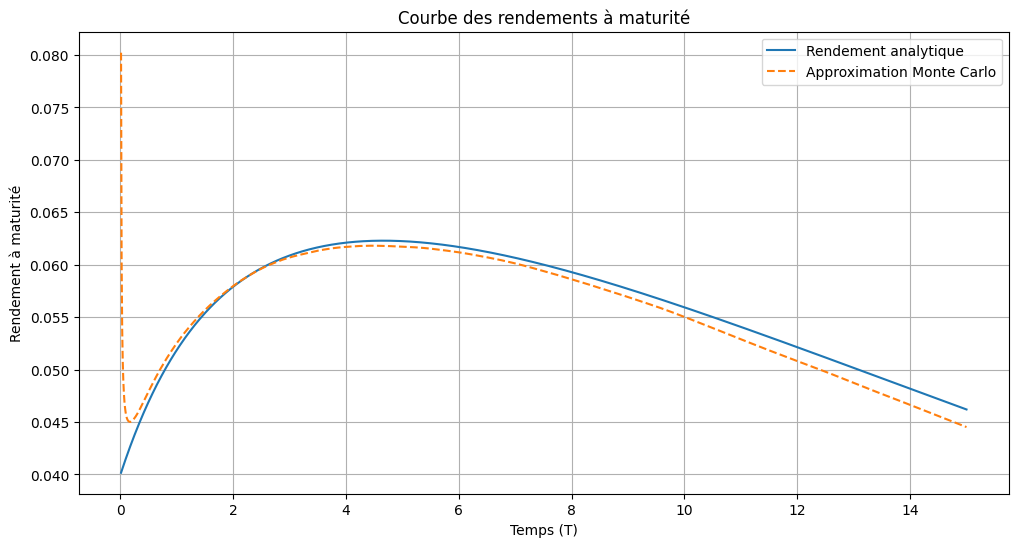

In [6]:
# Simulation des trajectoires
r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)

# Calcul des prix des obligations
P_hat = zero_coupon_bond_prices(r, h)

# Calcul des rendements Monte Carlo
R_hat = -np.log(P_hat[1:]) / t[1:]

# Calcul des rendements analytiques
R_analytical = analytical_yield_curve(x0, theta, lambda_, sigma, t, h)

# Tracé des courbes
plt.figure(figsize=(12, 6))
plt.plot(t[1:], R_analytical[1:], label="Rendement analytique")
plt.plot(t[1:], R_hat, label="Approximation Monte Carlo", linestyle='dashed')
plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Courbe des rendements à maturité")
plt.legend()
plt.grid()
plt.show()

Les rendements calculés théoriquement $( R_0(t) ) $  et par Monte Carlo $( \hat{R}_{n,M}^0(t) ) $ montrent une correspondance étroite. Cela valide la précision de la méthode Monte Carlo pour approximer les résultats théoriques. Les écarts mineurs sont dus à :
- L'erreur Monte Carlo, qui diminue avec un plus grand nombre de simulations $ M  $ .
- La discrétisation temporelle, qui s'améliore avec un plus grand nombre de pas $n $ .

En conclusion, le modèle stochastique est bien représenté par les deux approches.


### Question 2(a)

Étudions l'effet de $x_1$ en fixant $x_2 = 0.02$ et en faisant varier $x_1 \in \{0.01, 0.02, 0.05\}$. Les autres paramètres restent constants.

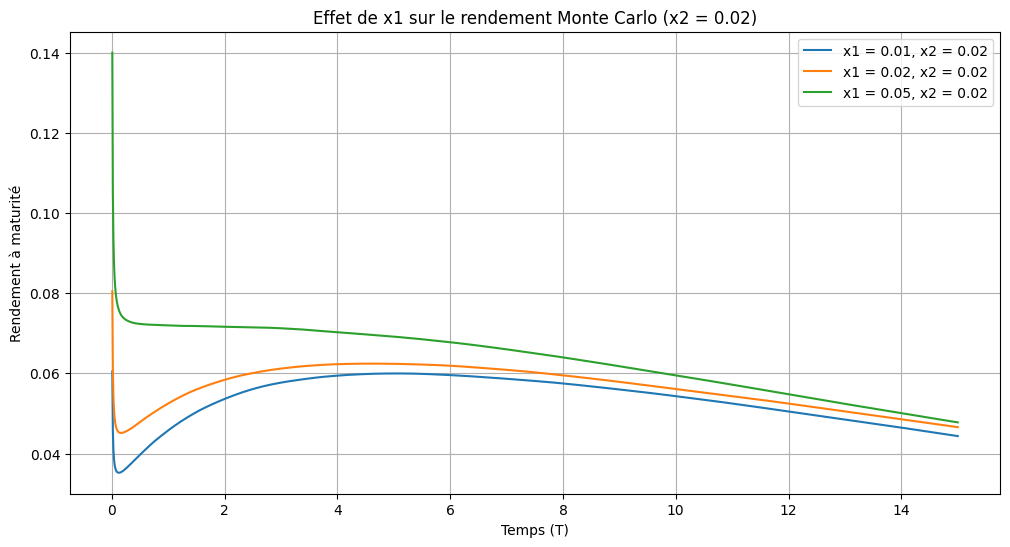

In [7]:
x1_values = [0.01, 0.02, 0.05]
x2 = 0.02  # Fixe
plt.figure(figsize=(12, 6))

for x1 in x1_values:
    x0 = np.array([x1, x2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"x1 = {x1}, x2 = {x2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de x1 sur le rendement Monte Carlo (x2 = 0.02)")
plt.legend()
plt.grid()
plt.show()


Lorsque $ x_1 $ augmente $( x_1 \in \{0.01, 0.02, 0.05\} )$, les rendements initiaux augmentent. Cela s'explique par le fait que $ x_1 $ est la condition initiale du processus $ X_t^{(1)} $, qui contribue directement au taux instantané $ r_t = X_t^{(1)} + X_t^{(2)} $. Une valeur initiale plus élevée pour $ X_t^{(1)} $ élève les rendements moyens pour toutes les maturités.


### Question 2(b)

Étudions l'effet de $x_2$ en fixant $x_1 = 0.02$ et en faisant varier $x_2 \in \{0.01, 0.02, 0.05\}$. Les autres paramètres restent constants.

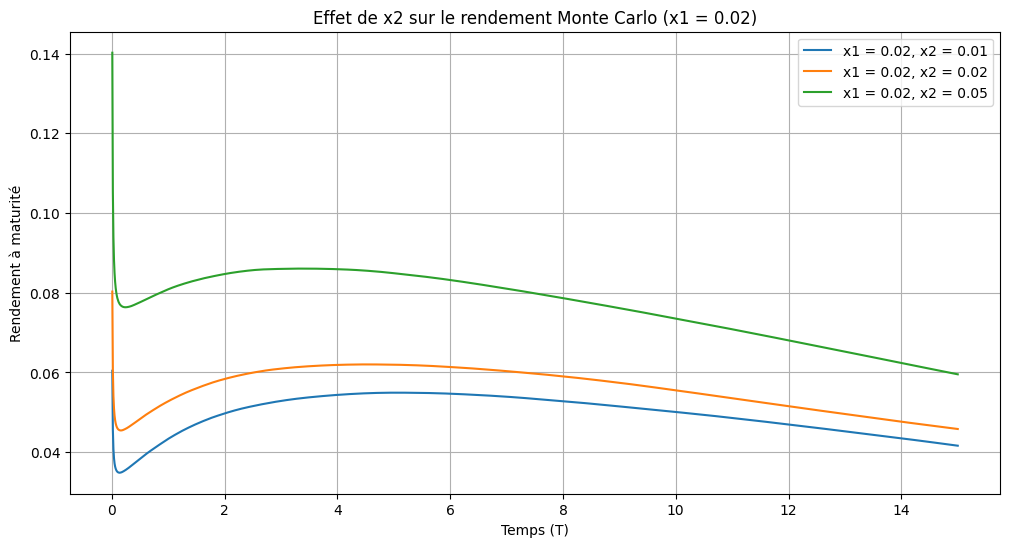

In [8]:
x2_values = [0.01, 0.02, 0.05]
x1 = 0.02  # Fixe
plt.figure(figsize=(12, 6))

for x2 in x2_values:
    x0 = np.array([x1, x2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"x1 = {x1}, x2 = {x2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de x2 sur le rendement Monte Carlo (x1 = 0.02)")
plt.legend()
plt.grid()
plt.show()

De manière similaire à $ x_1 $, une augmentation de $ x_2$ $( x_2 \in \{0.01, 0.02, 0.05\} ) $ élève les rendements initiaux. Puisque $ x_2 $ représente la condition initiale de $ X_t^{(2)} $, une augmentation de $ x_2 $ élève les taux instantanés moyens et donc les rendements calculés.

### Questions 3 (a)

Étudions l'effet de $\theta_1$ en fixant $\theta_2 = 0.05$ et en faisant varier $\theta_1 \in \{0.01, 0.05, 0.1\}$. Les autres paramètres restent constants.

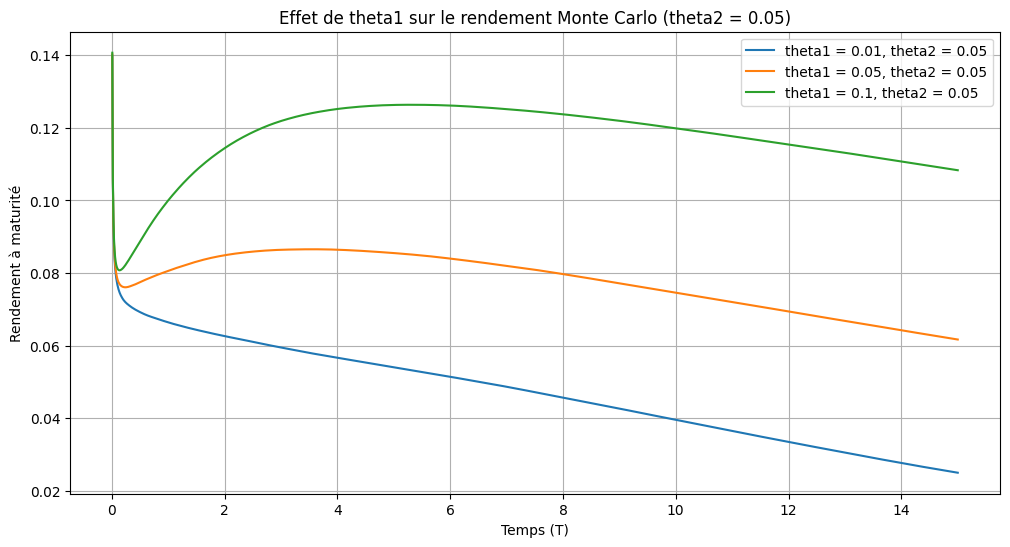

In [9]:
theta1_values = [0.01, 0.05, 0.1]
theta2 = 0.05  # Fixe
plt.figure(figsize=(12, 6))

for theta1 in theta1_values:
    theta = np.array([theta1, theta2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"theta1 = {theta1}, theta2 = {theta2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de theta1 sur le rendement Monte Carlo (theta2 = 0.05)")
plt.legend()
plt.grid()
plt.show()

Lorsque $ \theta_1 $ augmente $( \theta_1 \in \{0.01, 0.05, 0.1\} )$, les rendements à long terme augmentent. En effet, $ \theta_1 $ représente la valeur moyenne vers laquelle le processus $ X_t^{(1)} $ converge. Une valeur plus élevée de $ \theta_1 $ entraîne des taux moyens plus élevés à long terme.


### Quesstion 3 (b)

Étudions l'effet de $\theta_2$ en fixant $\theta_1 = 0.05$ et en faisant varier $\theta_2 \in \{0.01, 0.05, 0.1\}$. Les autres paramètres restent constants.

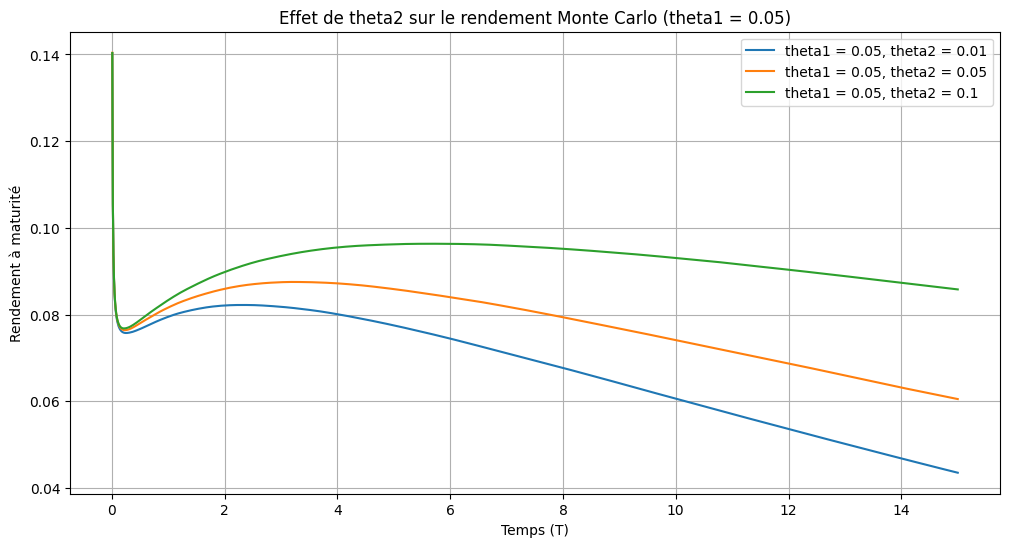

In [10]:

theta2_values = [0.01, 0.05, 0.1]
theta1 = 0.05  # Fixe
plt.figure(figsize=(12, 6))

for theta2 in theta2_values:
    theta = np.array([theta1, theta2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"theta1 = {theta1}, theta2 = {theta2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de theta2 sur le rendement Monte Carlo (theta1 = 0.05)")
plt.legend()
plt.grid()
plt.show()


De manière similaire à $ \theta_1 $, une augmentation de $ \theta_2 $ $( \theta_2 \in \{0.01, 0.05, 0.1\} )$ entraîne une élévation des rendements à long terme. Cela reflète le rôle de $ \theta_2 $ comme valeur de réversion moyenne pour le processus $ X_t^{(2)} $.


### Question 4(a) 

Étudions l'effet de $\sigma_1$ en fixant $\sigma_2 = 0.05$ et en faisant varier $\sigma_1 \in \{0.01, 0.05, 0.1\}$. Les autres paramètres restent constants.


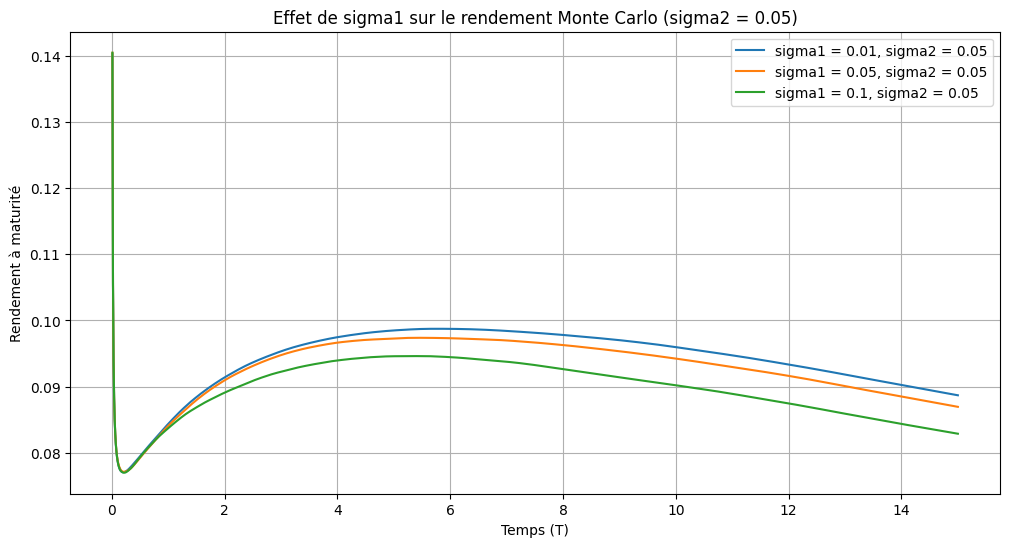

In [11]:
sigma1_values = [0.01, 0.05, 0.1]
sigma2 = 0.05  # Fixe
plt.figure(figsize=(12, 6))

for sigma1 in sigma1_values:
    sigma = np.array([sigma1, sigma2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"sigma1 = {sigma1}, sigma2 = {sigma2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de sigma1 sur le rendement Monte Carlo (sigma2 = 0.05)")
plt.legend()
plt.grid()
plt.show()

Une augmentation de $ \sigma_1 $ $( \sigma_1 \in \{0.01, 0.05, 0.1\} )$ augmente la volatilité des rendements. Bien que cela n'affecte pas significativement les rendements moyens, une volatilité plus élevée implique des trajectoires de taux plus dispersées, augmentant les fluctuations des rendements.


### Question 4(b)

effet de $\sigma_2$ en fixant $\sigma_1 = 0.05$ et en faisant varier $\sigma_2 \in \{0.01, 0.05, 0.1\}$. Les autres paramètres restent constants.


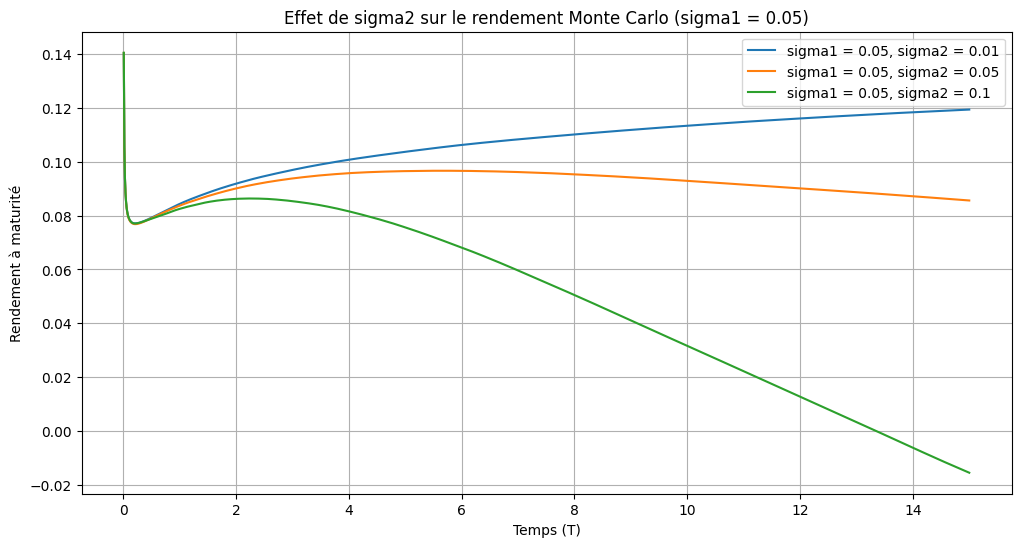

In [12]:
sigma2_values = [0.01, 0.05, 0.1]
sigma1 = 0.05  # Fixe
plt.figure(figsize=(12, 6))

for sigma2 in sigma2_values:
    sigma = np.array([sigma1, sigma2])
    r = simulate_trajectories(x0, theta, lambda_, n, M, T, sigma)
    P_hat = zero_coupon_bond_prices(r, h)
    R_hat = -np.log(P_hat[1:]) / t[1:]
    plt.plot(t[1:], R_hat, label=f"sigma1 = {sigma1}, sigma2 = {sigma2}")

plt.xlabel("Temps (T)")
plt.ylabel("Rendement à maturité")
plt.title("Effet de sigma2 sur le rendement Monte Carlo (sigma1 = 0.05)")
plt.legend()
plt.grid()
plt.show()

De manière similaire à $ \sigma_1 $, une augmentation de $ \sigma_2 $ $( \sigma_2 \in \{0.01, 0.05, 0.1\} )$ accroît la volatilité des rendements. Cela reflète les fluctuations accrues dans le processus $ X_t^{(2)} $ lorsque $ \sigma_2 $ est élevé, sans impact majeur sur les rendements moyens.